In [1]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

project_root = Path('..').resolve()
print('Project root:', project_root)

src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from uais.data.load_fraud_data import load_fraud_data
from uais.features.fraud_features import build_fraud_feature_table
from uais.supervised.train_fraud_supervised import FraudModelConfig, train_fraud_model
from uais.anomaly.train_isolation_forest import train_isolation_forest, compute_anomaly_score
from uais.ensembles.blending import blend_supervised_and_anomaly
from uais.utils.metrics import compute_classification_metrics
from uais.utils.plotting import plot_roc_curve, plot_pr_curve


Project root: /Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence


In [2]:
df_raw = load_fraud_data()
df_feats = build_fraud_feature_table(df_raw, 'Time', 'Amount', 'Class', drop_original_time=False)

target_col = 'Class'
X = df_feats.drop(columns=[target_col])
y = df_feats[target_col].astype(int)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print('Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)


Train: (3988456, 43) Val: (1329485, 43) Test: (1329486, 43)


In [3]:
# Check for empty feature set before training or validation/test
if (X_train.shape[1] == 0 or X_val.shape[1] == 0 or X_test.shape[1] == 0):
    print("No features available for training or validation/test. Skipping supervised model training.")
    model = None
    val_metrics = {}
    y_test_prob = np.zeros_like(y_test, dtype=float)
else:
    config = FraudModelConfig(model_type='hist_gb', max_depth=4, learning_rate=0.1, max_iter=200)
    model, val_metrics = train_fraud_model(X_train, y_train, X_val, y_val, config)
    print('Validation metrics (supervised):')
    for k, v in val_metrics.items():
        print(f"{k}: {v:.4f}")
    if hasattr(model, 'predict_proba'):
        y_test_prob = model.predict_proba(X_test)[:, 1]
    else:
        scores = model.decision_function(X_test)
        y_test_prob = 1.0 / (1.0 + np.exp(-scores))

Validation metrics (supervised):
roc_auc: 0.8750
pr_auc: 0.5219
f1: 0.5559
precision: 0.8265
recall: 0.4187
accuracy: 0.9991


In [4]:
iso_model, scaler = train_isolation_forest(X_train, contamination=0.01)
anomaly_scores_test = compute_anomaly_score(iso_model, scaler, X_test)


Hybrid metrics:
roc_auc: 0.8920
pr_auc: 0.3677
f1: 0.5642
precision: 0.8320
recall: 0.4268
accuracy: 0.9991


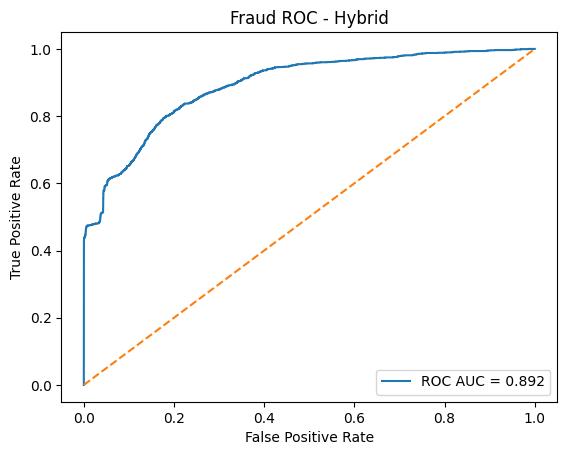

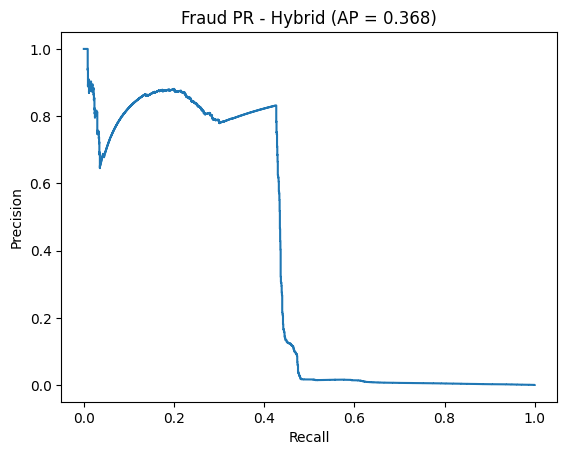

In [5]:
hybrid_scores = blend_supervised_and_anomaly(
    p_supervised=y_test_prob,
    anomaly_scores=anomaly_scores_test,
    alpha=0.7,
    beta=0.3,
)

hybrid_metrics = compute_classification_metrics(y_test.values, hybrid_scores, threshold=0.5)

print('Hybrid metrics:')
for k, v in hybrid_metrics.items():
    print(f"{k}: {v:.4f}")

plot_roc_curve(y_test.values, hybrid_scores, title='Fraud ROC - Hybrid')
plot_pr_curve(y_test.values, hybrid_scores, title='Fraud PR - Hybrid')
